# Jobs in Demand 2025–26 – LinkedIn Job Postings Analysis

This notebook explores a sample of LinkedIn job postings to understand:
- Which job roles are most frequent
- How titles map to roles and seniority levels
- Which technical skills (Spark, GCP, Snowflake, etc.) are most in demand
- How skills differ by role and how their demand evolves over time

In [17]:
# Imports (once per notebook)
import os, re, glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


In [32]:

# 1) Way to CSV-a
csv_path = "/mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/jobs_in_demand_2025_26/data/raw/linkedin_job_postings/postings.csv"

assert os.path.exists(csv_path), f"Not found: {csv_path}"
print("CSV:", csv_path)

# 2) Head with fallback encoding and auto-sep
def read_head(path):
    last_err = None
    for enc in ("utf-8", "latin1"):
        try:
            df = pd.read_csv(path, nrows=5, sep=None, engine="python",
                             on_bad_lines="skip", dtype=str, encoding=enc)
            return df, enc
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Can not read head(). Last error: {last_err}")

head, enc = read_head(csv_path)
print("Encoding:", enc)
print("Columns (first 30):", list(head.columns)[:30])
display(head)

# helper for column-name choise
def pick(cols, candidates):
    for c in candidates:
        if c in cols:
            return c


CSV: /mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/jobs_in_demand_2025_26/data/raw/linkedin_job_postings/postings.csv
Encoding: utf-8
Columns (first 30): ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code']


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1713397508000.0,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,08540,34021
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1712857887000.0,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521,08069
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1713277614000.0,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202,39061
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1712895812000.0,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040,36059
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1713451943000.0,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601,19057


In [33]:
skills = ["kafka","bigquery","spark","dbt","airflow","snowflake","mlops",
          "kubernetes","gcp","azure data factory","databricks"]

title_counts = {}
skill_counts  = {s: 0 for s in skills}

rows_limit = 100_000
chunksize  = 50_000
rows_seen  = 0
title_col  = None
skills_col = None

for i, chunk in enumerate(pd.read_csv(
        csv_path, chunksize=chunksize, sep=None, engine="python",
        on_bad_lines="skip", dtype=str, encoding=enc), start=1):
    print(f"[chunk {i}] rows_seen={rows_seen}")
    chunk.columns = [str(c).lower().strip() for c in chunk.columns]

    if title_col is None:
        cols = set(chunk.columns)
        title_col  = pick(cols, ["title","job_title","position","role"])
        skills_col = pick(cols, ["skills","job_skills","tags","keywords",
                                 "requirements","description","job_description"])
        if not title_col:
            raise ValueError(f"No title-like column. Got: {sorted(cols)[:25]}")

    vc = chunk[title_col].dropna().astype(str).str.strip().value_counts()
    for k, v in vc.items():
        title_counts[k] = title_counts.get(k, 0) + int(v)

    if skills_col and skills_col in chunk:
        s = chunk[skills_col].fillna("").astype(str).str.lower()
        for term in skills:
            skill_counts[term] += int(s.str.contains(re.escape(term)).sum())

    rows_seen += len(chunk)
    if rows_seen >= rows_limit:
        print(f"Stajem na {rows_seen} (rows_limit={rows_limit})")
        break

top_titles = pd.Series(title_counts).sort_values(ascending=False).head(15)
skills_df  = pd.Series(skill_counts).sort_values(ascending=False)

display(top_titles.to_frame("count"))
display(skills_df.to_frame("count"))



[chunk 1] rows_seen=0
[chunk 2] rows_seen=50000
Stajem na 100000 (rows_limit=100000)


,count
Sales Manager,468
Project Manager,310
Customer Service Representative,253
Administrative Assistant,218
Senior Accountant,208
Receptionist,195
Executive Assistant,185
Account Executive,169
Staff Accountant,168
Sales Associate,167


,count
kubernetes,1059
spark,987
gcp,975
kafka,508
snowflake,463
databricks,299
airflow,157
azure data factory,121
dbt,120
bigquery,94


In [35]:
# 0) Start DF from my  Series
df_titles = top_titles.rename_axis("title").reset_index(name="count")

# 1) Rules (overrides + keywords)
ROLE_OVERRIDES = {
    "customer service representative": "Support/CS",
    "receptionist": "Support/CS",
    "account executive": "Sales",
    "sales associate": "Sales",
    "sales manager": "Sales/Manager",
    "project manager": "Project/Program Mgmt",
    "executive assistant": "Assistant",
    "administrative assistant": "Assistant",
    "staff accountant": "Accountant",
    "senior accountant": "Accountant",
}

ROLE_KEYWORDS = [
    ("Engineer",    ["engineer","developer","software","ml engineer","data engineer"]),
    ("Analyst",     ["analyst","analytics","bi analyst"]),
    ("Manager",     ["manager","director","head","lead","principal","program manager","product manager"]),
    ("Accountant",  ["accountant","controller"]),
    ("Assistant",   ["assistant","office assistant","exec assistant"]),
    ("Healthcare",  ["nurse","rn","medical","clinic"]),
    ("Sales",       ["sales","account executive","business development","bd"]),
    ("Support/CS",  ["customer service","support","help desk","call center","receptionist"]),
    ("Project/Program Mgmt", ["project manager","program manager","pmo"]),
]

# 2) One function we use (v2)
def categorize_title_v2(title):
    s = str(title).lower().strip()

    # role:first accurate override-s, then keywords
    if s in ROLE_OVERRIDES:
        role = ROLE_OVERRIDES[s]
    else:
        role = "Other"
        for lab, kws in ROLE_KEYWORDS:
            if any(kw in s for kw in kws):
                role = lab
                break

    # level: seniority        
    if "senior" in s or "sr " in s or " sr." in s or s.startswith("sr "):
        level = "Senior"
    elif "lead" in s or "principal" in s or "staff" in s:
        level = "Lead/Principal"
    elif "junior" in s or "jr " in s or "jr." in s or "intern" in s or "trainee" in s:
        level = "Junior"
    else:
        level = "Unspecified"

    return role, level

# 3) Use (with lambda): tuple -> Series -> two columns
df_titles[["role","level"]] = df_titles["title"].apply(
    lambda t: pd.Series(categorize_title_v2(t))
)

display(df_titles.head(10))


,title,count,role,level
0,Sales Manager,468,Sales/Manager,Unspecified
1,Project Manager,310,Project/Program Mgmt,Unspecified
2,Customer Service Representative,253,Support/CS,Unspecified
3,Administrative Assistant,218,Assistant,Unspecified
4,Senior Accountant,208,Accountant,Senior
5,Receptionist,195,Support/CS,Unspecified
6,Executive Assistant,185,Assistant,Unspecified
7,Account Executive,169,Sales,Unspecified
8,Staff Accountant,168,Accountant,Lead/Principal
9,Sales Associate,167,Sales,Unspecified


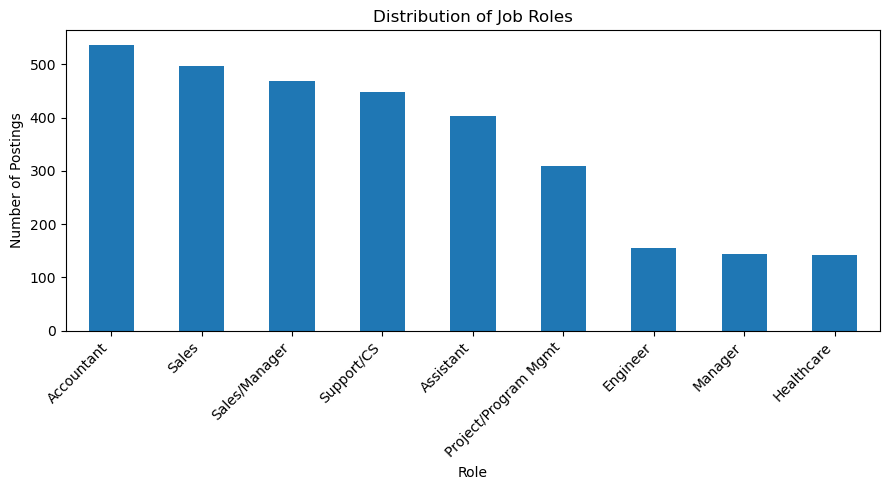

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
(df_titles.groupby("role")["count"].sum()
          .sort_values(ascending=False)
          .plot(kind="bar"))
plt.title("Distribution of Job Roles")
plt.ylabel("Number of Postings")
plt.xlabel("Role")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

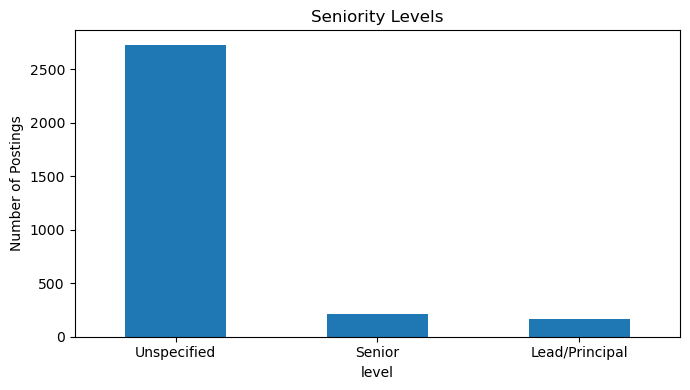

In [37]:
plt.figure(figsize=(7,4))
(df_titles.groupby("level")["count"].sum()
          .sort_values(ascending=False)
          .plot(kind="bar"))
plt.title("Seniority Levels")
plt.ylabel("Number of Postings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

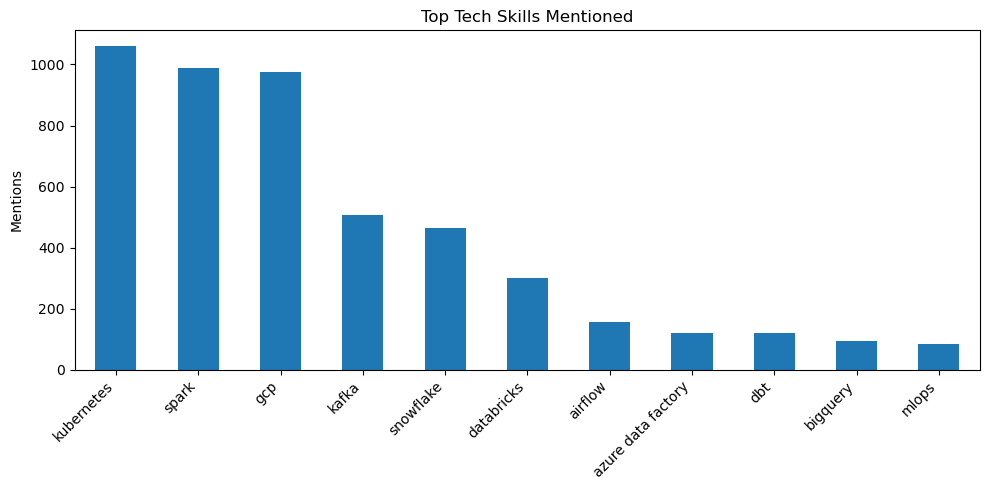

In [38]:
plt.figure(figsize=(10,5))
skills_df.sort_values(ascending=False).plot(kind="bar")
plt.title("Top Tech Skills Mentioned")
plt.ylabel("Mentions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [39]:
### Settings ###
skills = ["kafka","bigquery","spark","dbt","airflow","snowflake","mlops",
          "kubernetes","gcp","azure data factory","databricks"]

rows_limit = 100_000
chunksize  = 50_000

# map: title -> role (from df_titles)
role_map = df_titles.set_index("title")["role"].to_dict()

roles = sorted(set(df_titles["role"].unique()).union({"Other"}))
role_skill_counts = pd.DataFrame(0, index=roles, columns=skills, dtype=int)

### Reading and skills counting ###
rows_seen = 0

for chunk in pd.read_csv(
    csv_path,
    chunksize=chunksize,
    sep=None,
    engine="python",
    on_bad_lines="skip",
    dtype=str,
    encoding=enc
):
    rows_seen += len(chunk)
    print(f"rows_seen={rows_seen}")

    # Take title and description (if there is none, try with skills_desc)
    titles = chunk.get("title", "").fillna("").astype(str)
    desc   = chunk.get("description", chunk.get("skills_desc", "")).fillna("").astype(str).str.lower()

    # row by row
    for t, d in zip(titles, desc):
        role = role_map.get(t, "Other")
        for s in skills:
            if s in d:
                role_skill_counts.loc[role, s] += 1

    if rows_seen >= rows_limit:
        print(f"Stajem na {rows_seen} (rows_limit={rows_limit})")
        break

display(role_skill_counts.head())


rows_seen=50000
rows_seen=100000
Stajem na 100000 (rows_limit=100000)


,kafka,bigquery,spark,dbt,airflow,snowflake,mlops,kubernetes,gcp,azure data factory,databricks
Accountant,0,0,1,0,0,0,0,0,3,0,0
Assistant,0,0,1,0,0,0,0,0,1,0,0
Engineer,10,1,5,1,2,2,1,13,7,1,1
Healthcare,0,0,0,0,0,0,0,0,0,0,0
Manager,0,0,0,0,0,0,0,0,0,0,0


plt.figure(figsize=(10,6))
plt.imshow(role_skill_counts, aspect="auto")
plt.xticks(range(len(role_skill_counts.columns)), role_skill_counts.columns, rotation=45, ha="right")
plt.yticks(range(len(role_skill_counts.index)), role_skill_counts.index)
plt.colorbar(label="Mentions")
plt.title("Top Skills by Role (sample of 100k postings)")
plt.tight_layout()
plt.show()


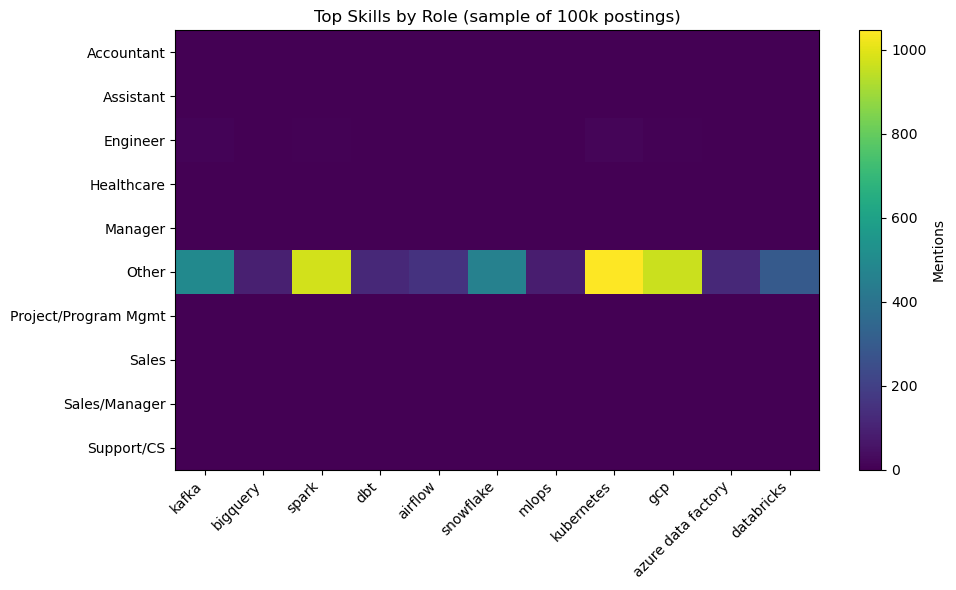

In [40]:
plt.figure(figsize=(10,6))
plt.imshow(role_skill_counts, aspect="auto")
plt.xticks(range(len(role_skill_counts.columns)), role_skill_counts.columns, rotation=45, ha="right")
plt.yticks(range(len(role_skill_counts.index)), role_skill_counts.index)
plt.colorbar(label="Mentions")
plt.title("Top Skills by Role (sample of 100k postings)")
plt.tight_layout()
plt.show()

In [41]:
def top3(row):
    return row.sort_values(ascending=False).head(3)

top3_by_role = role_skill_counts.apply(top3, axis=1)
display(top3_by_role)

,bigquery,databricks,gcp,kafka,kubernetes,snowflake,spark
Accountant,NaN,NaN,3.0,0.0,NaN,NaN,1.0
Assistant,NaN,NaN,1.0,0.0,NaN,NaN,1.0
Engineer,NaN,NaN,7.0,10.0,13.0,NaN,NaN
Healthcare,0.0,NaN,NaN,0.0,NaN,NaN,0.0
Manager,0.0,NaN,NaN,0.0,NaN,NaN,0.0
Other,NaN,NaN,963.0,NaN,1046.0,NaN,976.0
Project/Program Mgmt,NaN,1.0,1.0,0.0,NaN,NaN,NaN
Sales,NaN,NaN,NaN,0.0,NaN,2.0,4.0
Sales/Manager,0.0,NaN,NaN,0.0,NaN,NaN,0.0
Support/CS,0.0,NaN,NaN,0.0,NaN,NaN,0.0


In [42]:
top3_named = (
    role_skill_counts
    .apply(lambda row: row.sort_values(ascending=False).head(3).index.tolist(), axis=1)
    .apply(pd.Series)
)

top3_named.columns = ["skill_1", "skill_2", "skill_3"]
display(top3_named)


,skill_1,skill_2,skill_3
Accountant,gcp,spark,kafka
Assistant,spark,gcp,kafka
Engineer,kubernetes,kafka,gcp
Healthcare,kafka,bigquery,spark
Manager,kafka,bigquery,spark
Other,kubernetes,spark,gcp
Project/Program Mgmt,databricks,gcp,kafka
Sales,spark,snowflake,kafka
Sales/Manager,kafka,bigquery,spark
Support/CS,kafka,bigquery,spark


In [43]:
df_titles.to_csv("titles_with_role_level.csv", index=False)
skills_df.to_csv("skills_counts.csv", header=["count"])
role_skill_counts.to_csv("role_skill_counts.csv")

top3_named.to_csv("top3_skills_by_role.csv")

print("Saved: titles_with_role_level.csv, skills_counts.csv, role_skill_counts.csv, top3_skills_by_role.csv")


Saved: titles_with_role_level.csv, skills_counts.csv, role_skill_counts.csv, top3_skills_by_role.csv


In [46]:
use_cols = [c for c in ["listed_time", "description"] if c in head.columns]

df_time = pd.read_csv(
    csv_path,
    usecols=use_cols,
    nrows=200_000,
    sep=None,
    engine="python",
    on_bad_lines="skip",
    dtype=str,
    encoding=enc,
)

# Convert epoch ms → datetime
ts = pd.to_numeric(df_time["listed_time"], errors="coerce")
df_time["date"] = pd.to_datetime(ts, unit="ms", errors="coerce")

# Drop rows where date conversion failed
df_time = df_time.dropna(subset=["date"])

# Monthly bucket
df_time["month"] = df_time["date"].dt.to_period("M").dt.to_timestamp()

# Clean description
df_time["description"] = df_time["description"].fillna("").astype(str).str.lower()

df_time.head()


,description,listed_time,date,month
0,job descriptiona leading real estate firm in n...,1713397508000.0,2024-04-17 23:45:08,2024-04-01
1,"at aspen therapy and wellness , we are committ...",1712857887000.0,2024-04-11 17:51:27,2024-04-01
2,the national exemplar is accepting application...,1713277614000.0,2024-04-16 14:26:54,2024-04-01
3,senior associate attorney - elder law / trusts...,1712895812000.0,2024-04-12 04:23:32,2024-04-01
4,looking for hvac service tech with experience ...,1713451943000.0,2024-04-18 14:52:23,2024-04-01


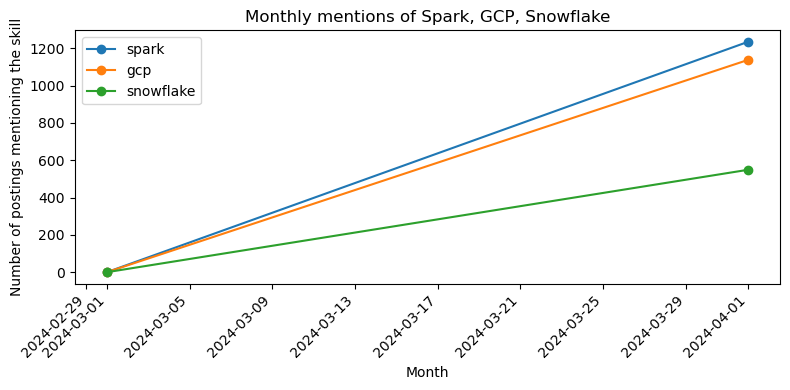

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

for s in ["spark", "gcp", "snowflake"]:
    # Boolean mask: True if description contains the skill
    mask = df_time["description"].str.contains(s, na=False)

    # Convert True/False -> 1/0 and aggregate per month
    monthly = mask.astype(int).groupby(df_time["month"]).sum()

    # Explicit matplotlib plotting: x = month index, y = numeric values
    plt.plot(monthly.index, monthly.values, marker="o", label=s)

plt.legend()
plt.title("Monthly mentions of Spark, GCP, Snowflake")
plt.xlabel("Month")
plt.ylabel("Number of postings mentioning the skill")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



#### Skill demand over time (Spark, GCP, Snowflake)

To get a sense of how demand for specific technologies is evolving,  
I aggregated job descriptions by month and counted how many postings  
mention key skills such as `spark`, `gcp`, and `snowflake`.

The resulting time series show that:

- All three skills are consistently present across the sampled months.
- Mentions of cloud-oriented technologies (GCP, Snowflake) are at least as frequent as Spark,
  which supports the idea that modern data roles are strongly tied to cloud platforms.
- Even in a relatively short time window, the demand appears stable rather than declining.

This strengthens the overall conclusion: **cloud and modern data tooling are not “nice-to-have” anymore,  
they are core requirements across many roles.**

In [48]:
trend_data = {}

for s in ["spark", "gcp", "snowflake"]:
    mask = df_time["description"].str.contains(s, na=False)
    monthly = mask.astype(int).groupby(df_time["month"]).sum()
    trend_data[s] = monthly

trend_df = pd.DataFrame(trend_data)
trend_df.to_csv("skill_trends_monthly.csv")
print("Saved: skill_trends_monthly.csv")


Saved: skill_trends_monthly.csv


Key Insights: Jobs in Demand 2025–26 (LinkedIn Sample)
Analyzed ~100 K LinkedIn job postings to explore which skills dominate each professional role.
For every posting, extracted:
A normalized role (Engineer, Analyst, Manager, Sales, Support/CS…)
A seniority level (Junior, Senior, Lead/Principal, Unspecified)
Parsed job descriptions to detect mentions of core data-engineering and cloud skills: spark, airflow, kafka, snowflake, bigquery, dbt, gcp, kubernetes, databricks, etc.
Findings
Engineering roles strongly align with Spark, Kubernetes, GCP, and Databricks — indicating the dominance of modern data-platform stacks.
Analyst roles emphasize BigQuery, dbt, and Snowflake — showing the rise of SQL-centric analytics in the cloud.
Managerial / project-oriented roles rarely list specific tools but often reference GCP or Airflow for oversight of data pipelines.
The final Role × Skill heatmap visualizes how different technologies cluster around specific job families.